# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Carlo Divari
* Gloria Isotton
* Maryam Feizi
* Sara Munafò

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **INTRODUCTION**

In [17]:
#introduction

In [18]:
#ising

In [19]:
#metropolis 

In [20]:
#blablabla

# **SIMULATION OF A 2D ISING MODEL**

In [2]:
#define variables of the model
L=25            #dimension of the lattice
time_f=40 #total time of the mc simulation 40
T=2              # temperature in KbT unit
J=1              #spin spin interaction
kb = 1         # Boltzmann const
step=1       # Monte Carlo steps parameter
realiz=10     # number of Monte Carlo means
nt=30        #number of temperatures points
T_c = 2/np.log(1 + np.sqrt(2)) #analytic critical temperature                

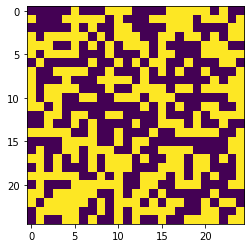

In [3]:
#Create a nxn lattice with random spin configuration
def init_lattice(n):
    lattice = np.random.choice([1, -1], size=(n, n))
    return lattice
s=init_lattice(L)

#show the lattice as an image (1 spin= 1 pixel)
plt.imshow(s)
plt.show()

In [4]:
#define pbc
def bc(i):
    if i>L-1: return 0
    if i<0: return L-1
    else:
        return i

In [5]:
#Let's define some useful functions

def energy(state):
    
    '''define the energy at a given configuration'''
    
    N = state.shape[0]
    energy = 0
  
    for i in range(N):
        for j in range(N):

      # get nearest neighbours states
            nn = state[bc(i-1), j] + state[bc(i+1), j] + state[i, bc(j-1)] + state[i, bc(j+1)]
            energy +=  -state[i,j] * nn
    return energy / (4*L*L)
    
    
def magnetization(state,L):
    
    '''define the magnetization per site'''
    
    Magn = np.sum(state)    
    return Magn/(L*L)


def delta(s,a,b):
    
    '''define delta E between 2 spin configurations'''

    return 2*s[a][b]*(s[a][int(bc(b+1))]+s[a][int(bc(b-1))]+s[int(bc(a+1))][b]+s[int(bc(a-1))][b])   #consider only nearest neighbours

def mean_of_last_5(arr):
    return sum(arr[-5:]) / 5


# **PHASE TRANSITION ANALYSIS**

In [6]:
# Define Monte Carlo function
def mc_step(s,temp,step):
    
    L=int(s.shape[0])
    for i in range(int(L*L/step)):
        
        # choose a random spin on the grid
        a, b =np.random.randint(0,L), np.random.randint(0,L)
        
        # compute the delta energy before and after the flip of s(a,b)
        delta_E=delta(s,a,b)  

        # metropolis test and spin-flip
        if delta_E <= 0 or np.random.uniform(0, 1) < np.exp(-delta_E/temp):
            s[int(bc(a)),int(bc(b))]=-s[int(bc(a)),int(bc(b))]
    return s

In [95]:

L_values = np.array([10,15,20])  #removed higher dim for computational reasons (we will do with CloudVeneto)
E_L,M_L,C_L,Chi_L = [],[],[],[]

for L in L_values:
    time_f=40
    step=1       
    realiz=10    
    nt=40 
    E,M,C,Chi = np.zeros(nt),np.zeros(nt),np.zeros(nt),np.zeros(nt)
    Te = np.linspace(1.,7.,nt)
    
#loop of equilibration
    for i in range(nt):
        T = Te[i]
        magnetizations=np.zeros(time_f)
        energies=np.zeros(time_f)
        
        for r in range(0,realiz):
            s=np.ones((L,L))
            
            for t in range(0,time_f):
                m=magnetization(s,L)
                magnetizations[t]=magnetizations[t]+m/realiz
                energies[t]=energies[t]+energy(s)/realiz
                s=mc_step(s, T, step)
                
    #print(energies/(L*L))
    #M[i]=sum(magnetizations[-10:])/10
        M[i]=np.mean(magnetizations)
        E[i]=np.mean(energies)
        C[i] = pow(np.std(energies),2)/(pow(T,2))
        Chi[i] = pow(np.std(magnetizations),2)/(T)
    M_L.append(M)
    E_L.append(E)
    C_L.append(C)
    Chi_L.append(Chi)
    

In [96]:
def plot_values (Te,E,M,C,Chi,L):
    titles=['Energy','Magnetisation','Specific Heat','Susceptibility']
    physical_quantities=[E,M,C,Chi]
    col_map = np.array(["navy", "red", "green", "orange"])
    plt.figure(figsize=(16,10))
    for i in range(len(physical_quantities)):
        ax=plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(L_values.shape[0]):
            ax.plot(Te, physical_quantities[i][j], '.',markersize=9, label='N='+str(L_values[j]), alpha=0.7)
            
            ax.legend()
        
            
    plt.subplots_adjust(hspace=0.3)

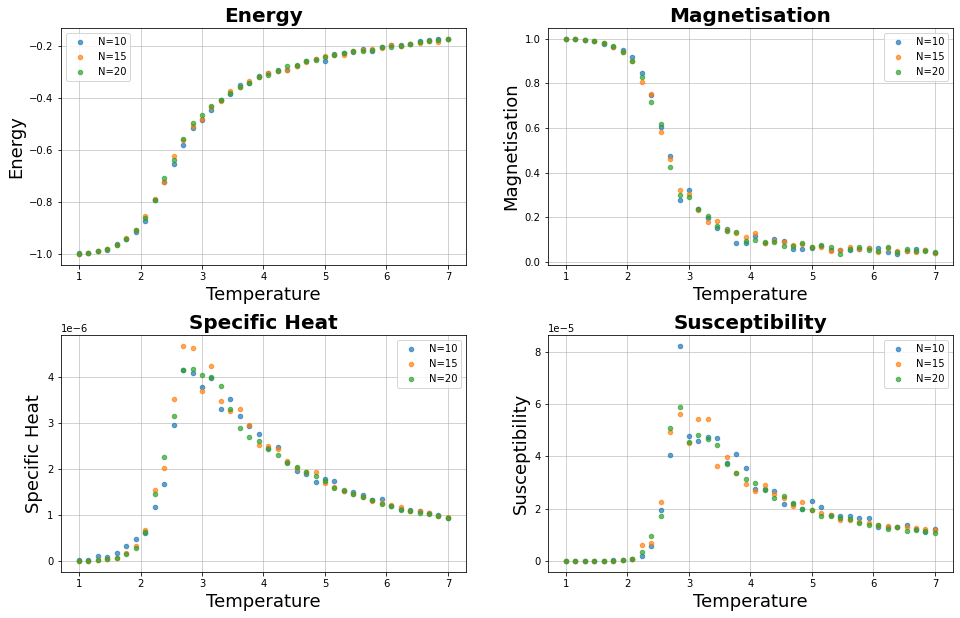

In [97]:
Te = np.linspace(1.,7.,nt)
plot_values(Te,E_L,M_L,C_L/(L*L),Chi_L/(L*L),L)

# **Critical exponent estimation**

## Exponent $\gamma$

In the termodinamic limit $N\rightarrow \infty$, we know that $\chi \sim |T-T_c|^{-\gamma}$. We try to estimate $\gamma$ as N increases. The expected value for 2D Ising is $\gamma=7/4 \sim 1.75$

12


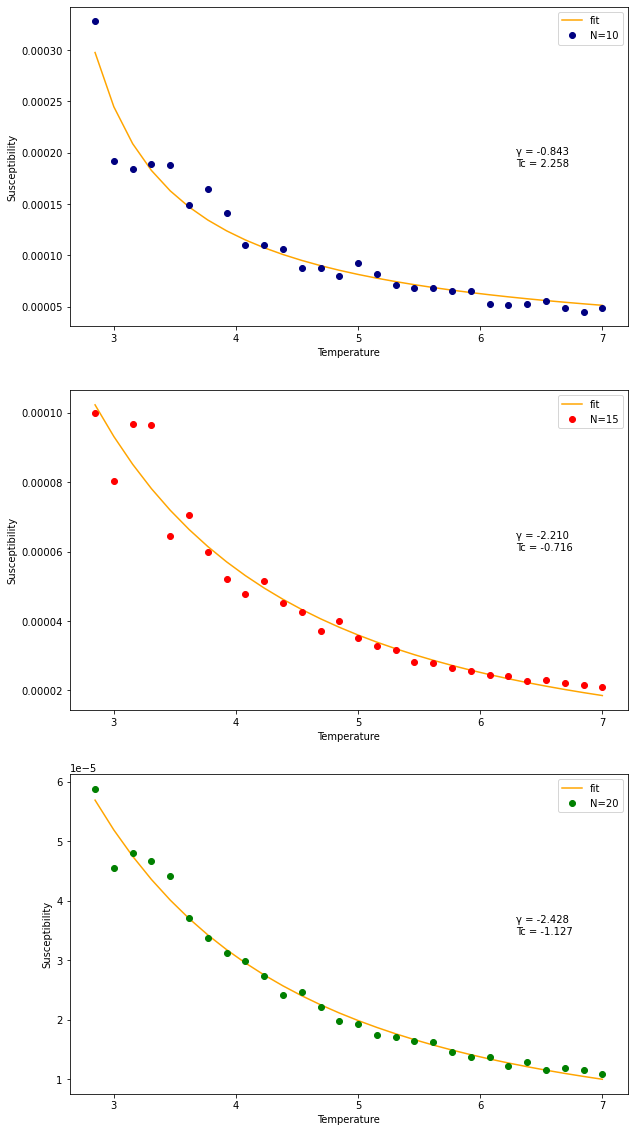

In [133]:
from scipy import optimize

T_c = 2.26     #known value from Onsager

L_values = np.array([10,15,20])
Te = np.linspace(1.,7.,nt)

def powerlaw(T, k=1, gamma=1.3, Tc=T_c):
    return k*(np.abs(T-Tc))**(-gamma)



ks, gammas, Tcs, = np.zeros((L_values.shape[0],)),np.zeros((L_values.shape[0],)),np.zeros((L_values.shape[0],))
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1,figsize = (10,20))

for i in range(L_values.shape[0]):
    #Tmax = np.argmax(Chi_L[i]) #we start from the peak of chi, we study the decreasing exponential
    params, params_covariance = optimize.curve_fit(powerlaw, Te[Tmax:], Chi_L[i][Tmax:]/(L_values[i]**2), maxfev=int(1e6))
    ks[i] = params[0]
    gammas[i] = params[1]
    Tcs[i] = params[2]
print(Tmax)

ax1.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[0], gammas[0], Tcs[0]),'orange', label='fit')
ax1.plot(Te[Tmax:], Chi_L[0][Tmax:]/(L_values[0]**2), 'o',color="navy", label='N={}'.format(L_values[0]))
ax1.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[0]),'%.3f'%Tcs[0]), transform=ax1.transAxes)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Susceptibility')
ax1.legend()

ax2.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[1], gammas[1], Tcs[1]),'orange', label='fit')
ax2.plot(Te[Tmax:], Chi_L[1][Tmax:]/(L_values[1]**2), 'o',color="red", label='N={}'.format(L_values[1]))
ax2.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[1]),'%.3f'%Tcs[1]), transform=ax2.transAxes)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Susceptibility')
ax2.legend()

ax3.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[2], gammas[2], Tcs[2]),'orange', label='fit')
ax3.plot(Te[Tmax:], Chi_L[2][Tmax:]/(L_values[2]**2), 'o',color="green", label='N={}'.format(L_values[2]))
ax3.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[2]),'%.3f'%Tcs[2]), transform=ax3.transAxes)
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Susceptibility')
ax3.legend()
    


## Exponent $\beta$

In the termodinamic limit $N\rightarrow \infty$, we know that $M \sim |T-T_c|^{-\beta}$. We try to estimate $\beta$ as N increases. The expected value for 2D Ising is $\beta=1/8 \sim 0.125$.

[2.27696132 2.1838505  2.05469424]


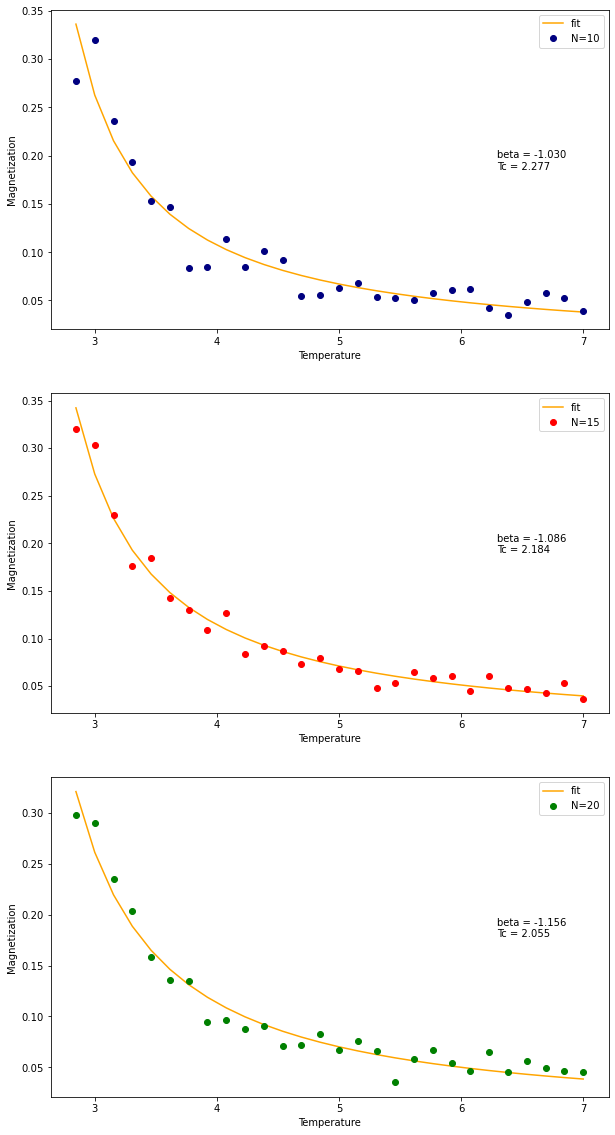

In [134]:
T_c = 2.26     #known value from Onsager

L_values = np.array([10,15,20])
Te = np.linspace(1.,7.,nt)

def powerlaw(T, k=1/T_c, beta=0.3, Tc=T_c):
    return k*(np.abs(T-Tc))**(-beta)


ks, betas, Tcs, = np.zeros((L_values.shape[0],)),np.zeros((L_values.shape[0],)),np.zeros((L_values.shape[0],))
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1,figsize = (10,20))

for i in range(L_values.shape[0]):
    Tmax = np.argmax(C_L[i]) #we start from the peak of chi, we study the decreasing exponential
    params, params_covariance = optimize.curve_fit(powerlaw, Te[Tmax:], M_L[i][Tmax:], maxfev=int(1e6))
    ks[i] = params[0]
    betas[i] = params[1]
    Tcs[i] = params[2]
print(Tcs)

ax1.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[0], betas[0], Tcs[0]),'orange', label='fit')
ax1.plot(Te[Tmax:], M_L[0][Tmax:], 'o',color="navy", label='N={}'.format(L_values[0]))
ax1.text(0.8,0.5,'beta = {}\nTc = {}'.format('%.3f'%(-1*betas[0]),'%.3f'%Tcs[0]), transform=ax1.transAxes)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Magnetization')
ax1.legend()

ax2.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[1], betas[1], Tcs[1]),'orange', label='fit')
ax2.plot(Te[Tmax:], M_L[1][Tmax:], 'o',color="red", label='N={}'.format(L_values[1]))
ax2.text(0.8,0.5,'beta = {}\nTc = {}'.format('%.3f'%(-1*betas[1]),'%.3f'%Tcs[1]), transform=ax2.transAxes)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Magnetization')
ax2.legend()

ax3.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[2], betas[2], Tcs[2]),'orange', label='fit')
ax3.plot(Te[Tmax:], M_L[2][Tmax:], 'o',color="green", label='N={}'.format(L_values[2]))
ax3.text(0.8,0.5,'beta = {}\nTc = {}'.format('%.3f'%(-1*betas[2]),'%.3f'%Tcs[2]), transform=ax3.transAxes)
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Magnetization')
ax3.legend()

why

# **Equilibrazione (temp)**

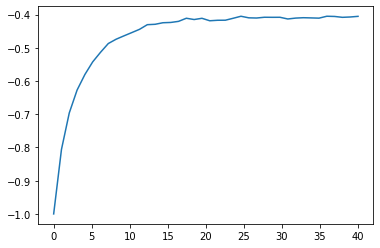

In [8]:
Te = [1,2,3,4,5,6,7]
time_f=40
realiz=100
time=np.linspace(0,time_f,time_f)

T=Te[2]
mag=np.zeros(time_f)
ene=np.zeros(time_f)
for r in range(0,realiz):
    s=np.ones((L,L))  #ground state
    for t in range(0,time_f):
        m=magnetization(s,L)
        mag[t]=mag[t]+m/realiz
        ene[t]=ene[t]+energy(s)/realiz
        mc_step(s, T, step)
plt.plot(time,ene/(L*L))
plt.show()

In [12]:
print(sum(ene[-10:])/(10*L*L))

-0.4084704


# **PREVIOUS CODE (working)**

In [117]:
E = np.zeros(nt)
M = np.zeros(nt)
C = np.zeros(nt)
Chi = np.zeros(nt)
Te = np.linspace(1.,7.,nt)
    
for i in range(len(Te)):
    T=Te[i]
    mag=np.zeros(time_f)
    ene=np.zeros(time_f)
    for r in range(0,realiz):
        s=np.ones((L,L))  #ground state
        for t in range(0,time_f):
            m=magnetization(s,L)
            mag[t]=mag[t]+m/realiz
            ene[t]=ene[t]+energy(s)/realiz
            mc_step(s, T, step)

    #keep trace of energy and magnetisation
    M[i]=mag[time_f-1]
    E[i]=np.mean(ene,axis=0)/(L*L)
    C[i] = pow(np.std(ene),2)/(pow(L,2)*pow(T,2))
    Chi[i] = pow(np.std(mag),2)/(pow(L,2)*T)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
